# HW4 - MobileNet V1 and V2: A PyTorch Tutorial
[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Amirmahdi Meighani



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy


In [ ]:
# Enter your information here
first_and_last_name = 'Radin Shahdaei'
std_number = '401106096'

![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [1]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader


Check your device. We recommend using GPU. You can use GPU with google colab.

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [3]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float or numpy.ndarray): Scale parameter (can be a scalar or vector of shape (features,)).
        beta (float or numpy.ndarray): Shift parameter (can be a scalar or vector of shape (features,)).
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    # Compute the mean and variance along the batch dimension
    mean = np.mean(x, axis=0)  # Shape: (features,)
    variance = np.var(x, axis=0)  # Shape: (features,)

    # Normalize the input
    x_hat = (x - mean) / np.sqrt(variance + epsilon)  # Shape: (batch_size, features)

    # Scale and shift
    y = gamma * x_hat + beta  # Shape: (batch_size, features)

    return y


In [4]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [5]:
from torch.utils.data import Subset

# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])


# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# Create a subset for training with half of the data
train_indices = list(range(len(train_set) // 2))  # Select the first half of the dataset
train_subset = Subset(train_set, train_indices)

# Create a DataLoader for the train subset without shuffle
train_loader = DataLoader(train_subset, batch_size=64, shuffle=False, num_workers=2)

# VALIDATION DATA
val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# Create DataLoader for validation set
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)

# TEST DATA
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# Create DataLoader for test set
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

# Print dataset information
print(f"Train subset samples: {len(train_subset)}")
print(f"Validation samples: {len(val_set)}")
print(f"Test samples: {len(test_set)}")


100%|██████████| 170M/170M [00:04<00:00, 34.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Train subset samples: 25000
Validation samples: 10000
Test samples: 10000


Explain what we did in transfor train and tranform test:<br/>

In `transform_train`, we applied data augmentation to improve generalization by:
- **RandomResizedCrop**: Cropping the image to 224x224 with random scaling between 50% and 100%.
- **RandomHorizontalFlip**: Randomly flipping images horizontally.
- **ToTensor**: Converting images to PyTorch tensors.
- **Normalize**: Standardizing pixel values using dataset-specific mean and standard deviation.

In `transform_test`, we prepared the test data without augmentation by:
- **Resize**: Resizing images to 224x224.
- **ToTensor**: Converting to PyTorch tensors.
- **Normalize**: Standardizing pixel values with the same statistics as training.

for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.


--- Displaying 32 images with shuffle=False ---


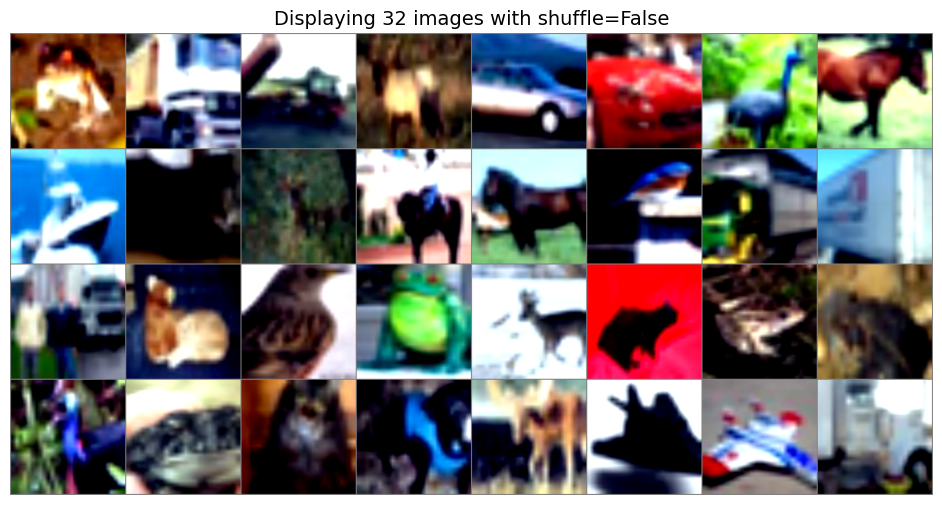

First 32 labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9]
All 128 labels in the batch: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9]



--- Displaying augmented images with shuffle=False ---


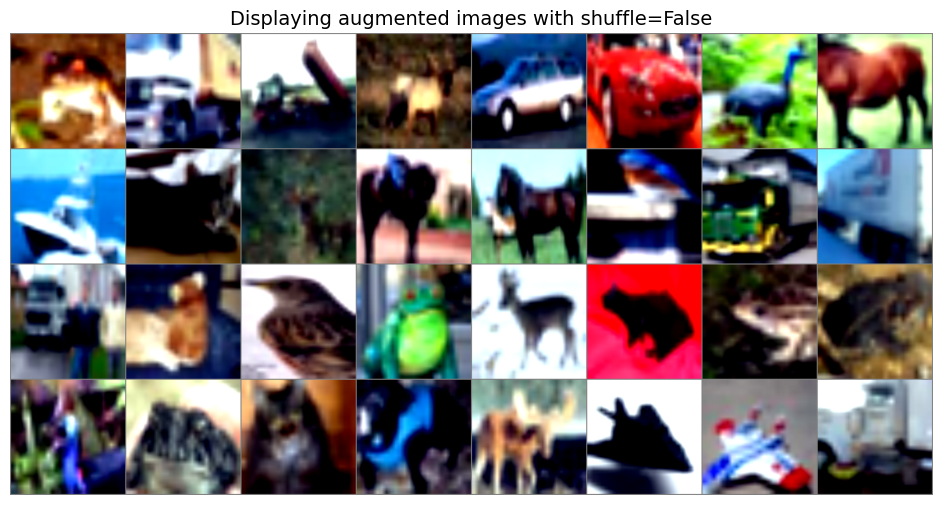

First 32 labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9]
All 128 labels in the batch: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9]



--- Displaying 32 images with shuffle=True ---


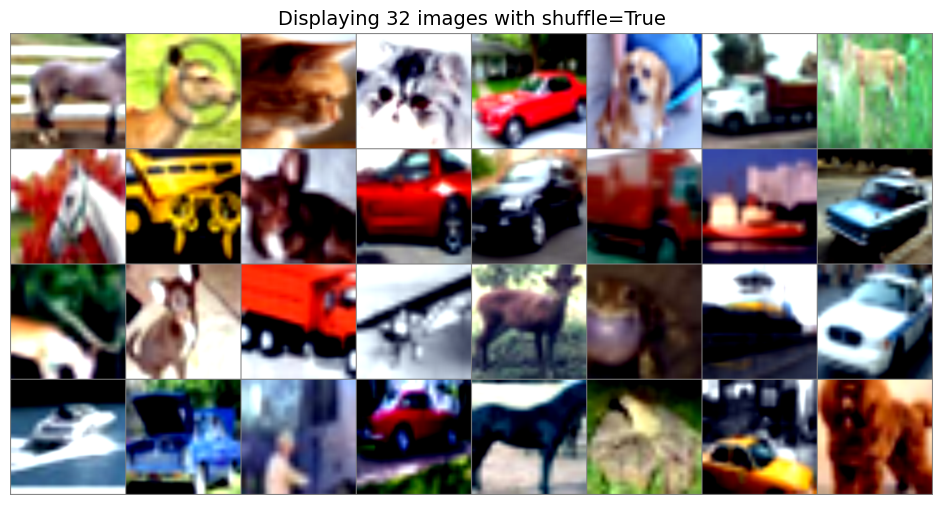

First 32 labels: [7, 4, 3, 3, 1, 5, 9, 4, 7, 9, 5, 1, 1, 9, 8, 1, 4, 5, 9, 0, 4, 6, 8, 1, 8, 1, 9, 1, 7, 6, 1, 5]
All 128 labels in the batch: [7, 4, 3, 3, 1, 5, 9, 4, 7, 9, 5, 1, 1, 9, 8, 1, 4, 5, 9, 0, 4, 6, 8, 1, 8, 1, 9, 1, 7, 6, 1, 5, 1, 2, 1, 3, 7, 1, 8, 0, 0, 4, 5, 3, 9, 3, 3, 5, 9, 1, 4, 9, 2, 4, 8, 1, 5, 6, 3, 7, 1, 0, 6, 0, 2, 1, 9, 5, 0, 1, 1, 8, 6, 0, 9, 0, 0, 7, 3, 1, 5, 2, 5, 3, 5, 6, 7, 2, 8, 0, 0, 8, 8, 9, 0, 6, 6, 0, 8, 2, 7, 8, 7, 9, 0, 4, 5, 3, 4, 9, 9, 5, 1, 8, 3, 5, 4, 2, 7, 1, 0, 7, 7, 9, 0, 1, 5, 5]


In [8]:
def imshow(img, nrow=8, title=None):
    """
    Displays a batch of images in a grid format.

    Parameters:
        img (torch.Tensor): Images in a batch as PyTorch tensor.
        nrow (int): Number of images per row.
        title (str, optional): Title for the plot.
    """
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

def display_images(data_loader, description, n_images=32, nrow=8):
    """
    Displays a batch of images along with their labels.

    Parameters:
        data_loader (DataLoader): PyTorch DataLoader for loading batches.
        description (str): Description to display before the images.
        n_images (int): Number of images to display.
        nrow (int): Number of images per row in the grid.
    """
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    print(f"\n--- {description} ---")
    imshow(torchvision.utils.make_grid(images[:n_images], nrow=nrow), title=description)
    print(f"First {n_images} labels: {labels[:n_images].tolist()}")
    print(f"All {len(labels)} labels in the batch: {labels.tolist()}")

# DataLoader without shuffle
train_loader_no_shuffle = DataLoader(train_subset, batch_size=128, shuffle=False)
display_images(train_loader_no_shuffle, "Displaying 32 images with shuffle=False")

# Check the same batch for augmentations
display_images(train_loader_no_shuffle, "Displaying augmented images with shuffle=False")

# DataLoader with shuffle
train_loader_shuffle = DataLoader(train_subset, batch_size=128, shuffle=True)
display_images(train_loader_shuffle, "Displaying 32 images with shuffle=True")


For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [9]:
from torch.utils.data import DataLoader
from typing import List, Tuple
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Assuming global variables 'device' and 'MODEL_SAVE_PATH' are defined elsewhere.

def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.
    """
    epoch_losses = []
    if train_mode:
        model.train()
    else:
        model.eval()

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        if train_mode:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train_mode):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            if train_mode:
                loss.backward()
                optimizer.step()

        epoch_losses.append(loss.item())

    return epoch_losses


def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        # Train
        train_loss = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        train_losses.append(sum(train_loss) / len(train_loss))
        print(f"Train Loss: {train_losses[-1]:.4f}")

        # Validate
        val_loss = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)
        val_losses.append(sum(val_loss) / len(val_loss))
        print(f"Validation Loss: {val_losses[-1]:.4f}")

        # Save model
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"Model saved to {MODEL_SAVE_PATH}")

    return train_losses, val_losses


def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    accuracy = correct / total * 100
    return accuracy


def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses.
    """
    plt.figure(figsize=(10, 6))

    # Plot smoothed training losses
    if c_window > 1:
        smoothed_train_losses = [
            sum(train_losses[max(0, i - c_window):i + 1]) / (i - max(0, i - c_window) + 1)
            for i in range(len(train_losses))
        ]
        plt.plot(smoothed_train_losses, label='Smoothed Train Loss')
    else:
        plt.plot(train_losses, label='Train Loss')

    # Plot validation losses
    plt.plot(val_losses, label='Validation Loss', linestyle='--')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [13]:
import torch.nn as nn

def conv_bn(inp, oup, stride):
    """
    Defines a standard convolutional layer with batch normalization and ReLU activation.

    Parameters:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride size for the convolution.

    Returns:
        nn.Sequential: A sequential container with Conv2D, BatchNorm, and ReLU layers.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

def conv_dw(inp, oup, stride):
    """
    Defines a depthwise separable convolution layer.
    Consists of depthwise convolution followed by pointwise convolution,
    each with batch normalization and ReLU activation.

    Parameters:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride size for the depthwise convolution.

    Returns:
        nn.Sequential: A sequential container with depthwise and pointwise convolutions.
    """
    return nn.Sequential(
        # Depthwise convolution
        nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),

        # Pointwise convolution
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )


Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.


### Depthwise Separable Convolutions: Parameter Reduction and Efficiency

1. **Traditional Convolution**:
   - **Input**: $C_{in}$ channels, **Output**: $C_{out}$ channels, Kernel size: $k \times k$.
   - Parameters: $k \times k \times C_{in} \times C_{out}$.

2. **Depthwise Separable Convolution**:
   - **Depthwise Convolution**: Applies one $ k \times k $ filter per input channel.
     - Parameters: $ k \times k \times C_{in} $.
   - **Pointwise Convolution**: Combines channels using $ 1 \times 1 $ filters.
     - Parameters: $ 1 \times 1 \times C_{in} \times C_{out} $.
   - **Total Parameters**: $ k \times k \times C_{in} + C_{in} \times C_{out} $.

3. **Comparison**:
   - **Reduction Factor**:
     $$
     \text{Reduction} = \frac{k \times k \times C_{in} \times C_{out}}{k \times k \times C_{in} + C_{in} \times C_{out}}
     $$
   - For example, with $ k=3 $, $ C_{in}=32 $, $ C_{out}=64 $:
     - Traditional: $ 3 \times 3 \times 32 \times 64 = 18,432 $.
     - Depthwise Separable: $ 3 \times 3 \times 32 + 32 \times 64 = 576 + 2,048 = 2,624 $.
     - **Reduction**: ~7x fewer parameters.

4. **Speedup**:
   - **Fewer Parameters**: Reduces memory and computation cost.
   - **Lower Computational Complexity**: Operations scale linearly in depthwise separable convolutions instead of quadratically in traditional convolutions.
   - **Result**: Faster inference, ideal for mobile/embedded applications.


Now please create your model.

In [11]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        """
        Initializes the MobileNet model.

        Parameters:
            n_class (int): Number of output classes (default: 1000 for ImageNet).
        """
        super().__init__()
        self.model = nn.Sequential(
            # Initial standard convolution
            conv_bn(3, 32, stride=2),  # Input: 3 (RGB channels), Output: 32, Stride: 2

            # Depthwise separable convolutions
            conv_dw(32, 64, stride=1),  # Depthwise + Pointwise: 32 -> 64
            conv_dw(64, 128, stride=2), # Depthwise + Pointwise: 64 -> 128
            conv_dw(128, 128, stride=1),# Depthwise + Pointwise: 128 -> 128
            conv_dw(128, 256, stride=2),# Depthwise + Pointwise: 128 -> 256
            conv_dw(256, 256, stride=1),# Depthwise + Pointwise: 256 -> 256
            conv_dw(256, 512, stride=2),# Depthwise + Pointwise: 256 -> 512

            # 5 depthwise separable blocks with stride 1
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),

            # Final depthwise separable layers
            conv_dw(512, 1024, stride=2), # Depthwise + Pointwise: 512 -> 1024
            conv_dw(1024, 1024, stride=1) # Depthwise + Pointwise: 1024 -> 1024
        )

        # Global average pooling and fully connected layer
        self.pool = nn.AdaptiveAvgPool2d(1)  # Output: (Batch, 1024, 1, 1)
        self.fc = nn.Linear(1024, n_class)   # Fully connected: 1024 -> n_class

    def forward(self, x):
        """
        Forward pass of the MobileNet model.

        Parameters:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, n_class).
        """
        x = self.model(x)        # Pass through the feature extractor
        x = self.pool(x)         # Global average pooling
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc(x)           # Fully connected layer
        return x


Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [15]:
# Instantiate the model
n_classes = 10  # CIFAR-10 has 10 classes
model = MobileNet(n_class=n_classes).to(device)

# Define training configurations
epochs = 10
lr = 1e-3

MODEL_SAVE_PATH = './model.pt'  # Define the path to save the model

# Train the model
train_losses, val_losses = train(
    train_loader=train_loader_shuffle,  # Train loader with shuffle=True
    val_loader=val_loader,              # Validation loader
    model=model,                        # MobileNet model
    epochs=epochs,                      # Number of epochs
    lr=lr                               # Learning rate
)


Epoch 1/10
Train Loss: 1.6383
Validation Loss: 1.4242
Model saved to ./model.pt

Epoch 2/10
Train Loss: 1.2996
Validation Loss: 1.3927
Model saved to ./model.pt

Epoch 3/10
Train Loss: 1.1137
Validation Loss: 1.0972
Model saved to ./model.pt

Epoch 4/10
Train Loss: 0.9913
Validation Loss: 1.0975
Model saved to ./model.pt

Epoch 5/10
Train Loss: 0.8820
Validation Loss: 0.8616
Model saved to ./model.pt

Epoch 6/10
Train Loss: 0.8043
Validation Loss: 0.7924
Model saved to ./model.pt

Epoch 7/10
Train Loss: 0.7300
Validation Loss: 0.8979
Model saved to ./model.pt

Epoch 8/10
Train Loss: 0.6779
Validation Loss: 0.6490
Model saved to ./model.pt

Epoch 9/10
Train Loss: 0.6225
Validation Loss: 0.6853
Model saved to ./model.pt

Epoch 10/10
Train Loss: 0.5824
Validation Loss: 0.6428
Model saved to ./model.pt


Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 78.24
Process validation time: 18.8554 s


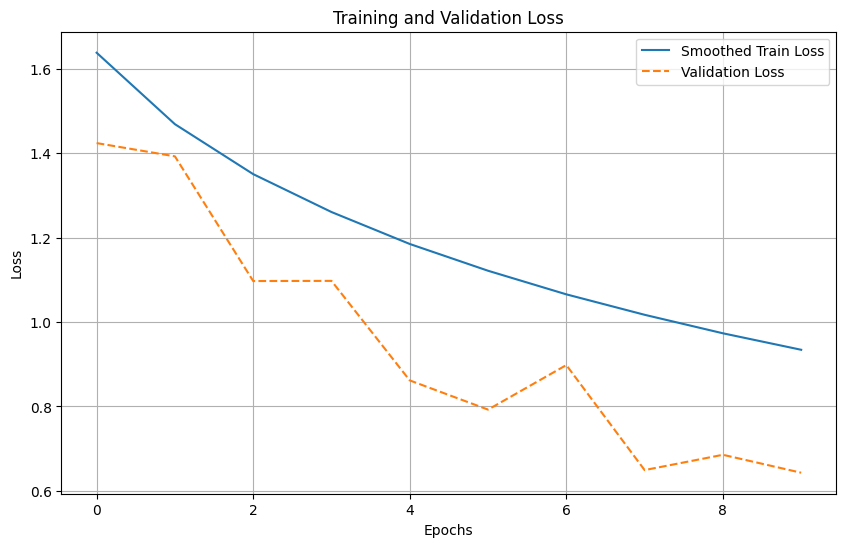

In [16]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


Depthwise separable convolutions reduce FLOPs compared to standard convolutions by splitting the operation into two parts:

1. **Standard Convolution FLOPs**:  
   $$
   \text{FLOPs} = H \times W \times C_{in} \times C_{out} \times k^2
   $$

2. **Depthwise Separable Convolution FLOPs**:  
   - **Depthwise**: $ H \times W \times C_{in} \times k^2 $
   - **Pointwise**: $ H \times W \times C_{in} \times C_{out} $  
   - **Total**: $ H \times W \times (C_{in} \times k^2 + C_{in} \times C_{out}) $

**Speedup**:  
$$
\text{Speedup} = \frac{C_{out} \times k^2}{k^2 + C_{out}}
$$

For typical values $(k=3, C_{in}=32, C_{out}=64$):  
- **Standard Convolution**: $ 18,432 \times H \times W $ FLOPs  
- **Depthwise Separable**: $ 2,336 \times H \times W $ FLOPs  
- **Speedup**: $ \frac{18,432}{2,336} \approx 7.9 $, supporting the claim of being **8-9x faster**.

## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [17]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [19]:
# Instantiate the NormalCNN model
normal_cnn = NormalCNN(n_class=10).to(device)  # CIFAR-10 has 10 classes

# Define training configurations
epochs = 2
lr = 1e-3

# Measure training time for NormalCNN
train_losses_normal, val_losses_normal = train(
    train_loader=train_loader_shuffle,  # Train loader with shuffle=True
    val_loader=val_loader,              # Validation loader
    model=normal_cnn,                   # NormalCNN model
    epochs=epochs,                      # Number of epochs
    lr=lr                               # Learning rate
)


Epoch 1/2
Train Loss: 1.9811
Validation Loss: 1.8898
Model saved to ./model.pt

Epoch 2/2
Train Loss: 1.7440
Validation Loss: 1.6309
Model saved to ./model.pt


Batch_size=128, epochs=2, lr=0.001
Val accuracy = 38.29
Process validation time: 21.2906 s


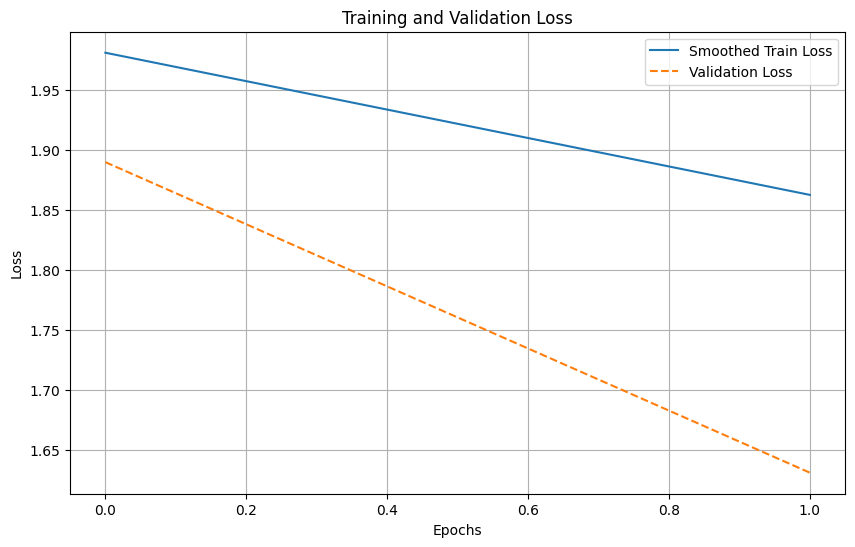

In [21]:
start = time.time()
val_acc = get_acc(normal_cnn, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses_normal, val_losses_normal)

Compare speed of learning and validating in normal CNN vs MobileNet

### Speed Comparison: Normal CNN vs. MobileNet

1. **Training Speed**:
   - **Normal CNN**: 2 epochs took **6 minutes** → **3 minutes per epoch**.
   - **MobileNet**: 10 epochs took **24 minutes** → **2.4 minutes per epoch**.
   - **Result**: **MobileNet is ~20% faster** per epoch compared to Normal CNN.

2. **Validation Speed**:
   - Validation for both models is similar since the data size and operations (e.g., forward pass without backpropagation) are comparable. The slight difference in speed is mainly due to the lighter architecture of MobileNet.

3. **Conclusion**:
   - MobileNet trains faster than Normal CNN due to its reduced computational complexity from depthwise separable convolutions, making it more suitable for efficient learning and deployment on resource-constrained devices.

In [22]:
def count_parameters(model):
    """
    Counts the total number of trainable parameters in a model.

    Args:
        model (nn.Module): The model to analyze.

    Returns:
        int: Total number of parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Instantiate the models
mobilenet = MobileNet(n_class=10).to(device)  # MobileNet
normal_cnn = NormalCNN(n_class=10).to(device)  # Normal CNN

# Count parameters
mobilenet_params = count_parameters(mobilenet)
normal_cnn_params = count_parameters(normal_cnn)

# Print results
print(f"Number of parameters in MobileNet: {mobilenet_params:,}")
print(f"Number of parameters in Normal CNN: {normal_cnn_params:,}")


Number of parameters in MobileNet: 3,217,226
Number of parameters in Normal CNN: 28,279,338


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [23]:
# Instantiate the new model for CIFAR-100
model = MobileNet(n_class=100).to(device)

# Load the pre-trained model weights (CIFAR-10 model)
pretrained_dict = torch.load('model.pt')  # Load the saved model weights from disk
model_dict = model.state_dict()           # Get the current model's state_dict

# Filter out unnecessary keys from the pretrained_dict
# Keep only the keys that match the current model's architecture
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}

# Update the model's state_dict with the filtered keys
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

print("Pre-trained weights loaded into the model, excluding the final classification layer.")

Pre-trained weights loaded into the model, excluding the final classification layer.


<ipython-input-23-aa0480533c55>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load('model.pt')  # Load the saved model weights from disk


**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [24]:
# Freezing layers up to the 7th block
freeze_up_to = 7  # Freeze layers up to the 7th convolutional block
layer_count = 0

for name, param in model.named_parameters():
    if "model" in name:  # Ensure we're freezing parameters inside the `model` Sequential
        layer_count += 1
        if layer_count <= freeze_up_to:
            param.requires_grad = False  # Freeze the layer
        else:
            break  # Stop after freezing the desired layers

print(f"Frozen up to the first {freeze_up_to} layers.")

Frozen up to the first 7 layers.


**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [25]:
# TRAIN DATA
train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=True, num_workers=2)

# VALIDATION DATA
val_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

val_loader100 = torch.utils.data.DataLoader(
    val_set100, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 169M/169M [00:03<00:00, 44.9MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.


--- Original Training Images (No Shuffle) ---


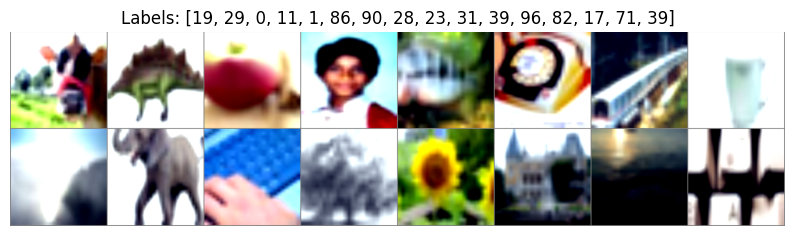


--- Augmented Training Images ---


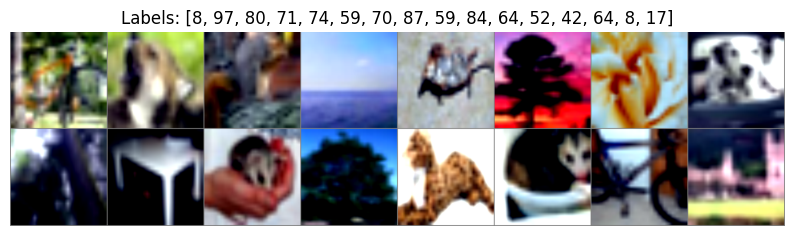

In [30]:
def imshow(img, labels=None, nrow=4):
    """
    Display a batch of images.

    Args:
        img (torch.Tensor): A batch of images as a PyTorch tensor.
        labels (List[int] or None): Optional, labels to display above the images.
        nrow (int): Number of images per row.
    """
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if labels:
        plt.title(f"Labels: {labels}", fontsize=12)
    plt.axis('off')
    plt.show()

# Show 16 training images with shuffle=False
train_loader_no_shuffle = DataLoader(train_set100, batch_size=16, shuffle=False, num_workers=2)
data_iter_no_shuffle = iter(train_loader_no_shuffle)
images, labels = next(data_iter_no_shuffle)

print("\n--- Original Training Images (No Shuffle) ---")
imshow(torchvision.utils.make_grid(images, nrow=8), labels=[labels[i].item() for i in range(len(labels))])

# Show the same batch to check augmentation
print("\n--- Augmented Training Images ---")
images, labels = next(data_iter_no_shuffle)  # DataLoader applies augmentations automatically
imshow(torchvision.utils.make_grid(images, nrow=8), labels=[labels[i].item() for i in range(len(labels))])


Do CIFAR10 and CIFAR100 use the same images but with diffrent labesl?(maybe you should search)

**answer**

Now train your model using your functions.

In [31]:
epochs = 7
lr = 2e-4
train_losses, val_losses = train(train_loader100, val_loader100, model, epochs, lr)


Epoch 1/7
Train Loss: 3.1265
Validation Loss: 2.8630
Model saved to ./model.pt

Epoch 2/7
Train Loss: 2.7713
Validation Loss: 2.6084
Model saved to ./model.pt

Epoch 3/7
Train Loss: 2.5210
Validation Loss: 2.4058
Model saved to ./model.pt

Epoch 4/7
Train Loss: 2.3420
Validation Loss: 2.2738
Model saved to ./model.pt

Epoch 5/7
Train Loss: 2.1899
Validation Loss: 2.1793
Model saved to ./model.pt

Epoch 6/7
Train Loss: 2.0721
Validation Loss: 2.0749
Model saved to ./model.pt

Epoch 7/7
Train Loss: 1.9644
Validation Loss: 2.0287
Model saved to ./model.pt


Get some metrics and plot your losses.

Batch_size=128, epochs=7, lr=0.0002
Val accuracy = 44.54
Process validation time: 18.2295 s


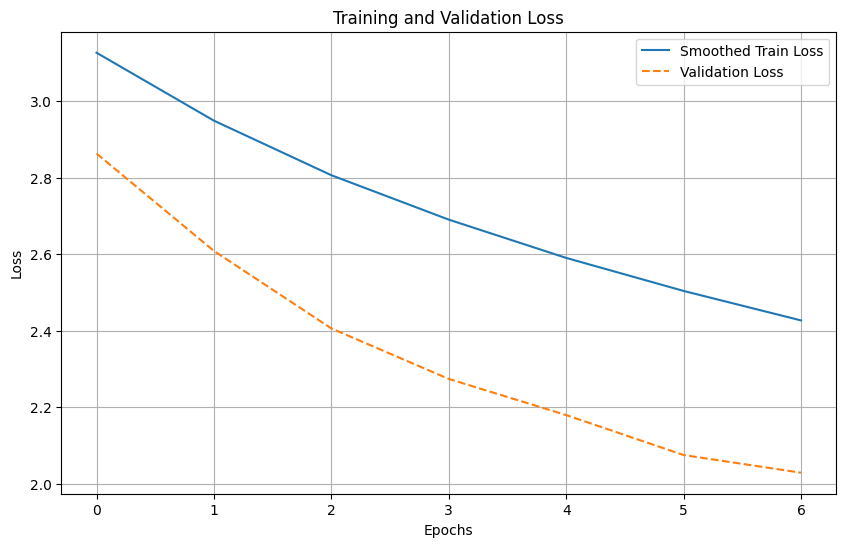

In [32]:
start = time.time()
val_acc = get_acc(model, val_loader100)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now where are going to implement the model. First complete the below functions and class.

What is ReLU6 Activation Function? Why do we use that?

### **ReLU6 Activation Function**

**Definition**:
- ReLU6 is a variant of the ReLU (Rectified Linear Unit) activation function that clips the output to a maximum value of 6.
- The mathematical formula is:
  $$
  \text{ReLU6}(x) = \min(\max(0, x), 6)
  $$

**Why Use ReLU6?**
1. **Numerical Stability in Low-Precision Environments**:
   - MobileNetV2 is designed for mobile and embedded devices, where computations are often performed with reduced precision (e.g., 8-bit integers instead of 32-bit floats).
   - ReLU6 ensures that activations remain within a bounded range \([0, 6]\), reducing numerical instability during these computations.

2. **Prevents Exploding Activations**:
   - By capping the maximum activation value, ReLU6 prevents large values from propagating through the network, which could lead to unstable gradients.

3. **Compatibility with Mobile Applications**:
   - The bounded output of ReLU6 is particularly useful when deploying models on hardware accelerators like Edge TPUs, where precision and efficiency are critical.

4. **Regularization Effect**:
   - The upper bound acts as a mild regularizer by restricting the range of activations, helping the model generalize better.

ReLU6 is integral to MobileNetV2, ensuring stability, efficiency, and compatibility with mobile and embedded applications while maintaining performance. Let me know if you’d like further clarification or examples! 🚀

In [33]:
import torch
import torch.nn as nn

def conv_bn(inp, oup, stride):
    """
    Standard convolution followed by batch normalization and ReLU6 activation.

    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride for the convolution layer.

    Returns:
        nn.Sequential: The convolution block.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_1x1_bn(inp, oup):
    """
    1x1 pointwise convolution followed by batch normalization and ReLU6 activation.

    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.

    Returns:
        nn.Sequential: The pointwise convolution block.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        """
        Inverted Residual block with optional skip connection.

        Args:
            inp (int): Number of input channels.
            oup (int): Number of output channels.
            stride (int): Stride for depthwise convolution.
            expand_ratio (float): Multiplier for the hidden dimension size.
        """
        super(InvertedResidual, self).__init__()
        self.stride = stride
        self.use_res_connect = self.stride == 1 and inp == oup

        hidden_dim = int(inp * expand_ratio)
        layers = []
        if expand_ratio != 1:
            # Pointwise convolution to increase channel depth
            layers.append(conv_1x1_bn(inp, hidden_dim))

        # Depthwise convolution
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
        ])

        # Pointwise-linear convolution to reduce channel depth
        layers.append(nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, padding=0, bias=False))
        layers.append(nn.BatchNorm2d(oup))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass with optional residual connection.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [34]:
class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_multiplier=1.0):
        """
        MobileNetV2 model implementation.

        Args:
            n_class (int): Number of output classes.
            input_size (int): Input image size (default: 224).
            width_multiplier (float): Multiplier for the number of channels.
        """
        super(MobileNetV2, self).__init__()

        # Configuration for inverted residual blocks: [t (expansion), c (output channels), n (repeats), s (stride)]
        interverted_residual_setting = [
            [1, 16, 1, 1],  # t=1, c=16, n=1, s=1
            [6, 24, 2, 2],  # t=6, c=24, n=2, s=2
            [6, 32, 3, 2],  # t=6, c=32, n=3, s=2
            [6, 64, 4, 2],  # t=6, c=64, n=4, s=2
            [6, 96, 3, 1],  # t=6, c=96, n=3, s=1
            [6, 160, 3, 2], # t=6, c=160, n=3, s=2
            [6, 320, 1, 1]  # t=6, c=320, n=1, s=1
        ]

        # Initial layer
        input_channel = int(32 * width_multiplier)
        self.last_channel = int(1280 * width_multiplier) if width_multiplier > 1.0 else 1280
        self.features = [conv_bn(3, input_channel, stride=2)]

        # Building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                stride = s if i == 0 else 1
                self.features.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel

        # Building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        self.features.append(nn.AdaptiveAvgPool2d(1))

        # Convert feature list to nn.Sequential
        self.features = nn.Sequential(*self.features)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, n_class)
        )

    def forward(self, x):
        """
        Forward pass through MobileNetV2.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten for the classifier
        x = self.classifier(x)
        return x


How did you create linear bottlenecks? How do they help?


### How Linear Bottlenecks are Created:
Linear bottlenecks are implemented in the **Inverted Residual Block** as follows:
1. **Expansion**:
   - The input is expanded by a factor (`expand_ratio`) using a **1x1 pointwise convolution**.
   - This increases the feature dimension, allowing the model to learn richer representations.

2. **Depthwise Convolution**:
   - A **3x3 depthwise convolution** operates on each channel independently, performing spatial filtering.

3. **Projection (Linear Bottleneck)**:
   - After the depthwise convolution, the features are reduced back to the original input size using another **1x1 pointwise convolution**.
   - **No ReLU** is applied at this stage, creating a **linear bottleneck**.

---

### Why Linear Bottlenecks are Important:
1. **Prevents Information Loss**:
   - Using a non-linear activation function like ReLU after reducing dimensions can clip negative values, discarding important information.
   - Linear bottlenecks preserve these subtle variations, maintaining information integrity in low-dimensional spaces.

2. **Improves Accuracy**:
   - Avoiding ReLU at the bottleneck stage reduces representational bottleneck effects, allowing the network to retain more discriminative power.

3. **Enhances Efficiency**:
   - By keeping the dimensionality low in the bottleneck stage, fewer parameters and computations are required, reducing the overall model complexity.

4. **Enables Compact Models**:
   - Linear bottlenecks work seamlessly with other MobileNetV2 components (e.g., depthwise separable convolutions, inverted residuals) to create compact yet powerful models, suitable for mobile and edge devices.

---

Linear bottlenecks are a crucial innovation in MobileNetV2, striking a balance between efficiency and accuracy while being highly suitable for resource-constrained environments.

Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [35]:
model = MobileNetV2(n_class=10).to(device)
epochs = 10
lr = 1e-3
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)


Epoch 1/10
Train Loss: 1.6702
Validation Loss: 1.4876
Model saved to ./model.pt

Epoch 2/10
Train Loss: 1.3242
Validation Loss: 1.2521
Model saved to ./model.pt

Epoch 3/10
Train Loss: 1.1078
Validation Loss: 1.0202
Model saved to ./model.pt

Epoch 4/10
Train Loss: 0.9626
Validation Loss: 0.8980
Model saved to ./model.pt

Epoch 5/10
Train Loss: 0.8521
Validation Loss: 0.7893
Model saved to ./model.pt

Epoch 6/10
Train Loss: 0.7926
Validation Loss: 0.7487
Model saved to ./model.pt

Epoch 7/10
Train Loss: 0.7351
Validation Loss: 0.6925
Model saved to ./model.pt

Epoch 8/10
Train Loss: 0.6958
Validation Loss: 0.6782
Model saved to ./model.pt

Epoch 9/10
Train Loss: 0.6568
Validation Loss: 0.6347
Model saved to ./model.pt

Epoch 10/10
Train Loss: 0.6277
Validation Loss: 0.5983
Model saved to ./model.pt


Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 79.75
Process validation time: 18.5393 s


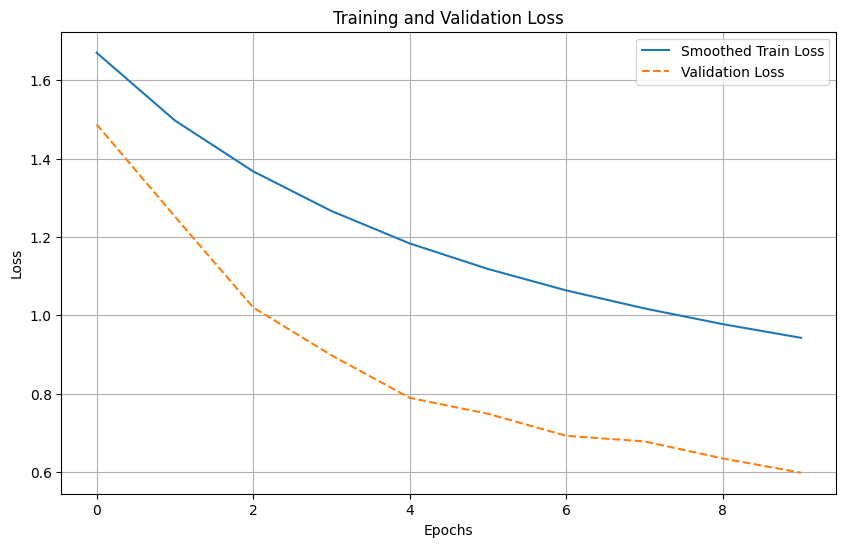

In [36]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [37]:
def count_parameters(model):
    """
    Counts the total number of trainable parameters in a model.

    Args:
        model (nn.Module): The model to analyze.

    Returns:
        int: Total number of parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Iterate over width multipliers from 0.1 to 1.0 with step 0.1
width_multipliers = [round(i * 0.1, 1) for i in range(1, 11)]
for wm in width_multipliers:
    model = MobileNetV2(n_class=1000, input_size=224, width_multiplier=wm)
    num_params = count_parameters(model)
    print(f"Width Multiplier: {wm}, Number of Parameters: {num_params:,}")


Width Multiplier: 0.1, Number of Parameters: 1,350,133
Width Multiplier: 0.2, Number of Parameters: 1,451,238
Width Multiplier: 0.3, Number of Parameters: 1,586,634
Width Multiplier: 0.4, Number of Parameters: 1,756,148
Width Multiplier: 0.5, Number of Parameters: 1,965,448
Width Multiplier: 0.6, Number of Parameters: 2,199,581
Width Multiplier: 0.7, Number of Parameters: 2,471,982
Width Multiplier: 0.8, Number of Parameters: 2,778,586
Width Multiplier: 0.9, Number of Parameters: 3,119,396
Width Multiplier: 1.0, Number of Parameters: 3,504,872


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [46]:
MNv2_path = './MNv2WMmodel.pt'

# Function to load a pretrained model with filtered state dictionary
def load_pretrained_model(model, checkpoint_path, device):
    """
    Loads a pretrained model with a filtered state dictionary.

    Args:
        model (nn.Module): The model to load weights into.
        checkpoint_path (str): Path to the checkpoint file.
        device (torch.device): The device to map the model and weights.

    Returns:
        nn.Module: The model with loaded weights.
        List[str]: Missing keys in the model's state_dict.
        List[str]: Unexpected keys in the checkpoint's state_dict.
    """
    # Load the checkpoint
    state = torch.load(checkpoint_path, map_location=device)

    # Filter the state dictionary
    model_state_dict = model.state_dict()
    filtered_state_dict = {k: v for k, v in state.items() if k in model_state_dict and model_state_dict[k].shape == v.shape}
    model.load_state_dict(filtered_state_dict, strict=False)

    # Identify missing and unexpected keys
    missing_keys = [k for k in model_state_dict if k not in filtered_state_dict]
    unexpected_keys = [k for k in state if k not in model_state_dict]

    return model, missing_keys, unexpected_keys

# Instantiate the MobileNetV2 model
pretrained_model = MobileNetV2(n_class=10, width_multiplier=0.5).to(device)

# Load pretrained weights and get missing/unexpected keys
pretrained_model, missing_keys, unexpected_keys = load_pretrained_model(pretrained_model, MNv2_path, device)

# Print missing and unexpected keys
if missing_keys:
    print(f"Missing keys: {missing_keys}")
if unexpected_keys:
    print(f"Unexpected keys: {unexpected_keys}")

# Measure validation accuracy and processing time
start = time.time()
val_acc = get_acc(pretrained_model, val_loader)
end = time.time()

print(f"Validation Accuracy: {val_acc:.2f}%")
print(f"Validation Time: {end - start:.4f} seconds")


<ipython-input-46-be3464b66674>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(checkpoint_path, map_location=device)


Validation Accuracy: 74.32%
Validation Time: 19.1585 seconds


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

The **width multiplier ($\alpha$)** scales the number of input ($C_{\text{in}}$) and output ($C_{\text{out}}$) channels for each layer, reducing the overall number of parameters.

For a convolutional layer:
$$
\text{Parameters} = \alpha^2 \times (k \times k \times C_{\text{in}} \times C_{\text{out}})
$$
where:
- $k$: Kernel size (e.g., 3 for $3 \times 3$ convolutions).
- $C_{\text{in}}, C_{\text{out}}$: Original input and output channels.

For pointwise ($1 \times 1$) convolutions:
$$
\text{Parameters} = \alpha^2 \times (C_{\text{in}} \times C_{\text{out}})
$$

For the whole model:
$$
\text{Total Parameters} = \alpha^2 \times P
$$
where $P$ is the number of parameters in the baseline model ($\alpha = 1$).

Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

#### 1. **Can it make the model faster?**
   - Yes, the **resolution multiplier ($\rho$)** scales the input image resolution. By decreasing the resolution, you reduce the computational cost for each convolution operation, leading to faster processing.
   - Lowering the resolution reduces the number of pixels processed, thus speeding up both training and inference.

#### 2. **Does it decrease the number of parameters?**
   - **No**, the number of parameters in the model remains largely unaffected by the resolution multiplier.
   - The parameters are related to the number of channels and the size of the kernels, not the spatial dimensions of the input.
   - However, the **computational complexity** (FLOPs) decreases because the reduced resolution means fewer pixels are involved in each operation, but the number of parameters stays the same.

Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

Yes, even with powerful GPUs:
- **Smaller Models for Mobile Devices**: For deployment on resource-constrained devices (e.g., smartphones, IoT devices), the number of parameters is still a critical factor because it directly impacts memory usage, processing time, and energy efficiency.
- **Efficient Computation**: A model with fewer parameters is more efficient, even on powerful GPUs, because it uses fewer resources for training and inference, making it more scalable and faster to deploy in production.

In summary, while GPUs can speed up training and inference, **smaller models with fewer parameters are still highly valuable** for their memory efficiency, energy efficiency, and faster deployment, especially for real-time and mobile applications.

## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for out task, but because of lack of resources we will just use it with terrible accuracy)

In [47]:
import timm

# Load a pre-trained ResNet18 fine-tuned on CIFAR-10
teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [48]:
start = time.time()
val_acc = get_acc(teacher_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))


Val accuracy = 9.4
Process validation time: 18.5958 s


Now create a mobilenetv2 model and then write the code to train it with Knowledge Distillation.

In [51]:
class DistillationLoss(nn.Module):
    """
    Custom loss function for knowledge distillation combining KL divergence
    and cross-entropy loss.

    Args:
        temperature (float): Temperature parameter for scaling logits.
        alpha (float): Weighting factor for distillation and classification loss.
    """
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.criterion = nn.CrossEntropyLoss()

    def forward(self,
                student_logits: torch.Tensor,
                teacher_logits: torch.Tensor,
                labels: torch.Tensor) -> torch.Tensor:
        """
        Compute the combined distillation and classification loss.

        Args:
            student_logits (torch.Tensor): Logits from the student model.
            teacher_logits (torch.Tensor): Logits from the teacher model.
            labels (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: The computed loss value.
        """
        # Cross-entropy loss between the student and the true labels
        hard_loss = self.criterion(student_logits, labels)

        # Soft loss between the student and the teacher using KL divergence
        soft_loss = nn.KLDivLoss(reduction='batchmean')(
            torch.nn.functional.log_softmax(student_logits / self.temperature, dim=1),
            torch.nn.functional.softmax(teacher_logits / self.temperature, dim=1)
        )

        # Combine the hard and soft losses
        loss = self.alpha * hard_loss + (1.0 - self.alpha) * soft_loss
        return loss

def train_student(teacher: nn.Module,
                  student: nn.Module,
                  train_loader: torch.utils.data.DataLoader,
                  test_loader: torch.utils.data.DataLoader,
                  device: torch.device,
                  epochs: int = 10,
                  lr: float = 0.01) -> None:
    """
    Train a student model using knowledge distillation.

    Args:
        teacher (nn.Module): Pre-trained teacher model.
        student (nn.Module): Student model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): DataLoader for test data.
        device (torch.device): Device to perform training on (CPU or GPU).
        epochs (int): Number of training epochs. Default is 10.
        lr (float): Learning rate for the optimizer. Default is 0.01.
    """
    teacher.eval()  # Set teacher model to evaluation mode
    student.train()  # Set student model to training mode

    criterion = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure inputs and labels are on the correct device

            optimizer.zero_grad()

            # Forward pass through both teacher and student
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            student_logits = student(inputs)

            # Compute the distillation loss
            loss = criterion(student_logits, teacher_logits, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

        # Optionally evaluate on test set after each epoch
        test_accuracy, test_time = evaluate_model(student, test_loader)
        print(f"Test Accuracy: {test_accuracy:.2f}%, Test Time: {test_time:.2f}s")

def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test set.

    Args:
        model (nn.Module): The model to evaluate.
        test_loader (DataLoader): DataLoader for test data.

    Returns:
        tuple: (accuracy, time taken for evaluation)
    """
    correct = 0
    total = 0
    start_time = time.time()

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    end_time = time.time()
    accuracy = 100 * correct / total
    evaluation_time = end_time - start_time

    return accuracy, evaluation_time

Train it for one epoch to just check if it works.

In [52]:
student = MobileNetV2(n_class=10)

# Ensure the student and teacher models are on the correct device
teacher_model = teacher_model.to(device)
student = student.to(device)

# Now train the student model with the correct device assignment
train_student(teacher_model, student, train_loader, val_loader, device, epochs=1, lr=0.001)


Epoch 1/1, Loss: 0.8681
Test Accuracy: 46.65%, Test Time: 18.81s


What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?


### Trade-offs of High Alpha (e.g., 0.9) vs. Low Alpha (e.g., 0.1):

1. **High Alpha (0.9)**:
   - **Pros**: More emphasis on **teacher's knowledge**, improving the student's ability to mimic the teacher’s output.
   - **Cons**: **Less focus on the true labels**, potentially leading to overfitting to the teacher’s behavior, which may reduce generalization to new or unseen data.
   - **Impact**: Better alignment with the teacher but could harm the student’s ability to generalize well to the target task.

2. **Low Alpha (0.1)**:
   - **Pros**: More focus on **true labels** (classification loss), encouraging better generalization and alignment with the ground truth.
   - **Cons**: Less emphasis on the **teacher’s knowledge**, potentially limiting the student’s ability to learn complex patterns from the teacher.
   - **Impact**: Better generalization to the target task but weaker alignment with the teacher’s knowledge.

## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.
- **MobileNet V2**: Added inverted residuals and linear bottlenecks to improve efficiency and performance, reducing memory use without sacrificing accuracy.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018